### Introduction

In this notebook I produce visualizations of eye fixations from reading tests plotted directly on the text images themselves. These fixations serve to give an intuitive sense of whether a student trouble reading a text. Disordered fixations on the text may suggest poor reading ability while highly ordered fixations may suggest good reading ability.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pandas.io.json import json_normalize
import json
#from scipy.stats import binom
import mysql.connector
import datetime
#import skimage.io as skimg
import io

# to insure 'use_pure' arg of connection exists
assert mysql.connector.__version__ >= '2.1.1'

%matplotlib inline

#### Load data

In [ ]:
file = './Data/Reading Tests v1 + v3.csv'
data = pd.read_csv(file)

#### Explore Data

Number of rows

In [7]:
len(data)

401

Check for NAs

In [4]:
data.isnull().sum()

test                   0
readingLesson          0
isOutloud              0
totalMicroseconds      0
questions             63
rightAnswers          63
gazes                115
fixations              0
version                0
words                  0
width                  0
height                 0
language               0
ageMin                 0
ageMax                 0
patient                0
birthday               0
gender               110
country                0
age                    0
dateAdded              0
dtype: int64

&NewLine;    
Some rows have fixations but no gaze data...

In [6]:
data.loc[data.gazes.isnull(), ['gazes','fixations', 'version']].groupby('version').size()

version
v1      1
v3    114
dtype: int64

#### Connect to MySQL Database function
Utility function used later in the plot fixation function to send a query to a MySQL database server.

In [9]:
def mysql_query(query, config):
    assert isinstance(query, str)
    assert isinstance(config, dict)
    assert all([i in config.keys() for i in ['user', 'password', 'host']])

    try:
        conn = mysql.connector.connect(**config)
        cursor = conn.cursor(dictionary = True)
        cursor.execute(query)
        # return cursor obj with data ready to retrieve
        result = cursor.fetchall()
        return(result)

    except mysql.connector.Error as error:
        print(f'Query failed to excute: {error}')

    finally:
        cursor.close()
        conn.close()

#### Plot fixations function
The function sends a query to a MySQL database server to retrieve the text image to plot the fixation points on top of. 

In [8]:
def plot_fixation(data_row, ax = None):
    assert isinstance(data_row, pd.Series)
    cols = pd.Series(['fixations', 'height', 'width', 'readingLesson', 'version'])
    assert cols.isin(data_row.index).all()
    json_str = data_row.fixations 
    ht = data_row.height 
    wd = data_row.width
    text_id = data_row.readingLesson 
    db = data_row.version 
    
    assert isinstance(json_str, str)
    assert isinstance(ht, float)
    assert np.issubdtype(type(text_id), np.integer)
    text_id = int(text_id)
    # left + right fixations for single student, dict
    json_dict = json.loads(json_str) 

    # build data frames
    # alternative: concatenate or reshape/pivot with eye indicator col
    df_l = pd.read_json(json.dumps(json_dict['L']))
    df_r = pd.read_json(json.dumps(json_dict['R']))
    # reset y coords from top of text image
    #df_l.Y = ht - df_l.Y # not necessary with orient='upper'
    #df_r.Y = ht - df_r.Y

    # retrieve text image from database
    config = {
        'user':'root',
        'password': '',
        'host': 'localhost',
        'use_pure':  True # this prevents decoding problem with the blob data
    }
    # nb: I encountered errors using recommended syntax for submitting string 
    # format vars i.e. passing them directly to cursor.execute()
    query = ("SELECT image FROM okimo_%s_copy.readinglessons"
                " where readingLesson = %s") % (db, text_id)
    result = mysql_query(query, config)
    # extract bytes string from 1 elem dict in 1 elem list 
    result = result[0]['image']
    # convert img jpg to np array
    np_img = plt.imread(io.BytesIO(result), 'jpg')
    #skimg.imread(io.BytesIO(result))
    
    # I am assuming (correctly) the rows are sorted chronologically

    # matplot lib approach
    # accept ax passed to function if given
    if ax == None:
        fig, ax = plt.subplots()
    ax.plot(df_l['X'], df_l['Y'], '-o', markersize=10, label='Left')
    ax.plot(df_r['X'], df_r['Y'], '-o', markersize=10, label='Right')
    # calling imshow with its default origin='upper' resets the 0 y-axis at the
    # top of the image
    ax.imshow(np_img, extent=(0,wd, ht, 0))
    ax.legend()
    #return(fig)

    # pandas plotting approach
    #ax = df_l.plot(kind='scatter', x='X', y='Y', s=100)
    #df_l.plot(kind='line', x='X', y='Y', label='Left', ax=ax)
    #df_r.plot(kind='scatter', x='X', y='Y', s=100, color='orange', ax=ax)
    #df_r.plot(kind='line', x='X', y='Y', ax=ax, label = 'Right')
    #plt.imshow(np_img, extent=(0,wd, ht, 0))

Try function

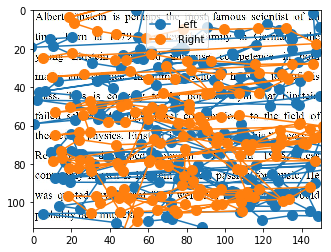

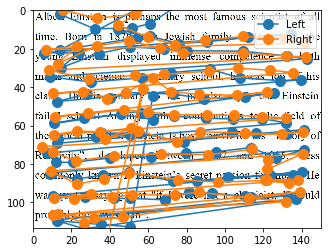

In [32]:
plot_fixation(data.loc[9,:])
plot_fixation(data.loc[8,:])

8 looks good
1 is sparse and off the page
9 is very dense but disordered

Note: we see that a number of the fixations are off the text boundaries 
themselves. I could expand the visualization to include the off text
visualizations later

### Create Reading Skill Ranking
I rank each reading test by reading comprehension score with tests that recieved the same comprehension score ranked by reading speed (seconds per word). Students with no comprehension score are ignored.
  
  
Calculate comprehension score as percent of answered questions that are correct. 

In [14]:
data['comp_score'] = data.rightAnswers/data.questions

Make time per word measure

In [15]:
data['read_speed'] = data.totalMicroseconds/data.words

In [16]:
data = data.sort_values(['comp_score', 'read_speed'], ascending = [False, True])
# can't use pd rank() bc it doesn't accomadate randing by multiple cols in 
# differing sort directions while excluding nans
data['reading_rank'] = np.nan
df_len = data.comp_score.notnull().sum()
mask = data.comp_score.notnull()
data.loc[mask, 'reading_rank'] = list(range(1, df_len+1))

**Note on reading metric:**  
Some students answered fewer than 6 qs, some even only 1 question. The signal provided by this comprehension score when only 2 or 3 questions were answered is likely minimal.
  
  
  
Take a look as the distribution of number of questions answered over the dataset.

In [11]:
data.questions.describe()

count    338.000000
mean       4.949704
std        1.235173
min        1.000000
25%        4.000000
50%        6.000000
75%        6.000000
max        6.000000
Name: questions, dtype: float64

We can see that 75% of patients answer 4 or more questions. (Does this correlate to campaign?)  
Some tests have no answered questions recorded.

  
One potential appoach to dealing with this is weight the comprehension metric with this formula $((1-p)\cdot k + p\cdot (n-k))/n$ where $k$ is the number of correct answers, $n$ is total number of questions answered, and $p$ is the probability of getting $k$ correct answers given $n$ total ansnwers if guessing randomly as derived from the binomial distribution. 

Another condiseration is that a student who gets .8 comprehension is ranked lower than someone with 1.0 comprehension even if she reads twice as
fast. Maybe such a fast .8 comprehension student should rank higher than that slow 1.0 comprehension student.

Also, Do we want to handicap reading performance by age, so that students 
score higher if they are younger than others reading the same text but get the same comprehension score. Further maybe we should only compare students who read age appropriate texts.

Note:
Do the reading ranks have to be split by text? by age?
Consider measuring how far off the text page a student wandered

#### Function to plot comprehension score against reading time
Language of test and whether test was read outloud is included as a variable to color each observation.

In [17]:
def plot_speed_comp(df, color_map = None):
    '''
    color_map options: 'lang', 'outloud'
    '''
    assert isinstance(df, pd.DataFrame)
    cols = pd.Series(['language', 'isOutloud', 'read_speed', 'comp_score'])
    assert cols.isin(df.columns).all()
    assert (color_map in ['lang', 'outloud', None])
    if color_map:
        maps = {'outloud': df['isOutloud'],
        'lang':df['language'].astype('category').cat.codes}
        color_map = maps[color_map]
        # with reading mode
        # with color by language, with category to int mapping
        # turquoise is spanish, purple is english
    else:
        color_map = 'b'
    plt.scatter(df.read_speed,df.comp_score, c=color_map, alpha=.5)
    plt.xlabel('Reading Speed \n (larger is slower)')
    plt.ylabel('Reading Comprehension Score \n (1 = perfect score)')

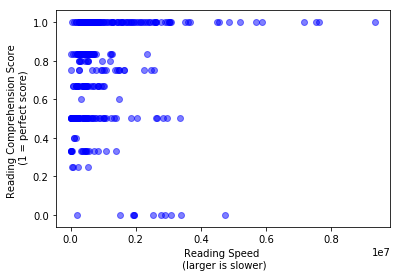

In [18]:
plot_speed_comp(data)

Plot with language displayed

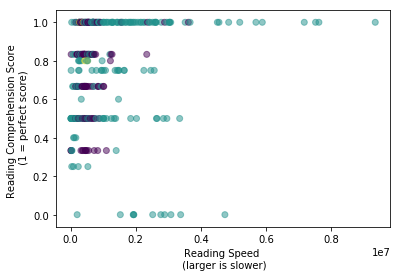

In [20]:
plot_speed_comp(data, color_map = 'lang')

Plot with an indicator for whether the text was read outloud

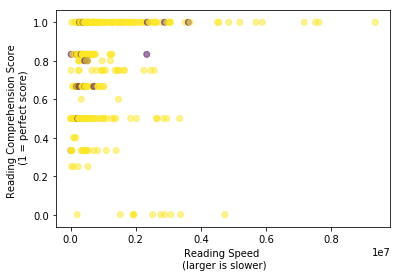

In [23]:
plot_speed_comp(data, color_map = 'outloud')

English seems more clustered in the middle percents, but hard to
gauge.

Look at distributions of language, country, and outloud reading across data.

In [26]:
data.language.value_counts()

es    212
en    185
fi      4
Name: language, dtype: int64

In [27]:
data.isOutloud.value_counts()

1    379
0     22
Name: isOutloud, dtype: int64

In [28]:
data.country.value_counts()

PY    213
GB    177
PH      5
US      4
AF      2
Name: country, dtype: int64

Note:
we see there is a slight trend to score higher if you take longer

### Plot Best and Worst Ranked Fixations

In [29]:
def plot_extremes(df, n_plots, col = 'reading_rank', with_data = False):
    assert (col in df.columns) & isinstance(col, str)
    assert isinstance(n_plots, int)
    assert isinstance(with_data, bool)
    fig, axes = plt.subplots(n_plots, 2)
    # flatten axes ndarray colomn wise
    axes = axes.flatten(order='F')
    # sort_values) could be redundant
    worst =df[col].dropna().sort_values()[-n_plots:].index
    best = df[col].dropna().sort_values()[:n_plots].index
    idxs = np.array([best, worst]).flatten()
    # iteraction through best then worst idxs
    for i, idx in enumerate(idxs):
        plot_fixation(df.loc[idx,:], ax= axes[i])
    axes[0].set_title('Best')
    axes[n_plots].set_title('Worst')
    if with_data:
        res = pd.concat([df.loc[best, :], df.loc[worst, :]], keys=['Best', 'Worst'])
        return(res)

#### Consider the in ENTIRE dataset

test  readingLesson  isOutloud  totalMicroseconds  questions  \
Best  4      40             44          1            1995249        1.0   
      390  2383             73          1            1769236        3.0   
      66   1139             58          1            9764689        6.0   
Worst 320  2195             73          1           49257995        3.0   
      400  2413             73          1           54023076        3.0   
      316  2188             73          1           75747393        3.0   

           rightAnswers                                              gazes  \
Best  4             1.0  [{"L":{"X":29.765209833780926,"Y":11.623618038...   
      390           3.0                                                NaN   
      66            6.0  [{"L":{"X":17.171697807312011,"Y":83.435592341...   
Worst 320           0.0                                                NaN   
      400           0.0                                                NaN   
      316           0.0                                                NaN   

                                                   fixations version  words  \
Best  4    {"L":[{"X":37.120370370370374,"Y":8.7962962962...      v1     60   
      390  {"L":[{"X":18.12037037037037,"Y":42.75,"T":118...      v3     16   
      66   {"L":[{"X":24.3,"Y":87.412500000000009,"T":197...      v1     60   
Worst 320  {"L":[{"X":189.01041666666666,"Y":148.19010416...      v3     16   
      400  {"L":[{"X":95.7421875,"Y":26.966145833333332,"...      v3     16   
      316  {"L":[{"X":51.953125,"Y":12.122395833333332,"T...      v3     16   

           ...  ageMax  patient    birthday  gender  country      age  \
Best  4    ...       7      654  1994-01-01       f       PY  23.6386   
      390  ...       5       25  2012-01-01     NaN       PY   6.5791   
      66   ...       5      783  1951-07-31       m       GB  66.7515   
Worst 320  ...       5      172  2011-01-01     NaN       PY   7.5756   
      400  ...       5       80  2012-01-01     NaN       PY   6.5791   
      316  ...       5      243  2009-01-01     NaN       PY   9.5743   

                     dateAdded comp_score    read_speed  reading_rank  
Best  4    2017-08-22 06:45:42        1.0  3.325415e+04           1.0  
      390  2018-07-31 08:01:16        1.0  1.105772e+05           2.0  
      66   2018-05-01 03:01:43        1.0  1.627448e+05           3.0  
Worst 320  2018-07-30 11:42:26        0.0  3.078625e+06         336.0  
      400  2018-07-31 11:17:25        0.0  3.376442e+06         337.0  
      316  2018-07-30 11:31:36        0.0  4.734212e+06         338.0  

[6 rows x 24 columns]

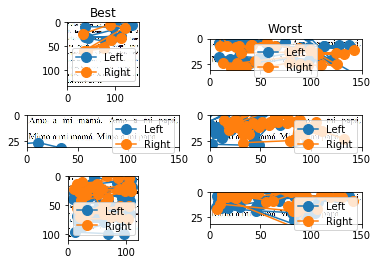

In [30]:
plot_extremes(data, 3, with_data = True)

We see many of both best and worst come from a very short text (number 73 from version v3). And only one test has all 6 questions answered, suggesting the reading scores may not be very reliable.

Notably the plurality of tests given used text 73: 61 tests out of 401.

In [39]:
data.groupby('version')['readingLesson'].value_counts()

version  readingLesson
v1       58               54
         68               46
         69               23
         67               22
         45               20
         66               18
         55               15
         44               11
         63                8
         65                5
         46                4
         62                4
         64                4
         53                3
         61                2
v3       73               61
         71               39
         72               22
         70               17
         45               12
         46               11
Name: readingLesson, dtype: int64

#### Consider Tests with More than 3 Answered Questions Excluding Text 73

test  readingLesson  isOutloud  totalMicroseconds  questions  \
Best  66   1139             58          1            9764689        6.0   
      97   1235             58          1           15209515        6.0   
      254  2037             46          1           18388397        5.0   
Worst 261  2071             72          1            5250113        4.0   
      269  2086             72          1           14188583        4.0   
      284  2118             71          1           15899411        4.0   

           rightAnswers                                              gazes  \
Best  66            6.0  [{"L":{"X":17.171697807312011,"Y":83.435592341...   
      97            6.0  [{"L":{"X":29.747816276550296,"Y":-8.366009902...   
      254           5.0  [{"L":{"X":9.0666163762410488,"Y":7.4804696694...   
Worst 261           1.0  [{"L":{"X":6.3258726305017863,"Y":90.096688270...   
      269           1.0  [{"L":{"X":-94.010416666666657,"Y":-25.234375,...   
      284           1.0  [{"L":{"X":-94.010416666666657,"Y":-56.40625,"...   

                                                   fixations version  words  \
Best  66   {"L":[{"X":24.3,"Y":87.412500000000009,"T":197...      v1     60   
      97   {"L":[{"X":16.875,"Y":0.675,"T":3268782,"D":78...      v1     60   
      254  {"L":[{"X":11.611111111111111,"Y":7.3888888888...      v3     70   
Worst 261  {"L":[{"X":4.700520833333333,"Y":88.5677083333...      v3     60   
      269  {"L":[{"X":87.825520833333329,"Y":152.39583333...      v3     60   
      284  {"L":[{"X":51.705729166666664,"Y":50.716145833...      v3     30   

           ...  ageMax  patient    birthday  gender  country      age  \
Best  66   ...       5      783  1951-07-31       m       GB  66.7515   
      97   ...       5      829  1986-11-05       f       GB  31.6797   
      254  ...       8        9  2010-01-01       m       PY   8.5530   
Worst 261  ...       7      149  2010-01-01     NaN       PY   8.5749   
      269  ...       7      151  2011-01-01     NaN       PY   7.5756   
      284  ...       6      195  2010-01-01     NaN       PY   8.5749   

                     dateAdded comp_score     read_speed  reading_rank  
Best  66   2018-05-01 03:01:43       1.00  162744.816667           3.0  
      97   2018-07-11 01:52:54       1.00  253491.916667           5.0  
      254  2018-07-22 20:05:49       1.00  262691.385714           6.0  
Worst 261  2018-07-30 05:33:24       0.25   87501.883333         325.0  
      269  2018-07-30 05:48:42       0.25  236476.383333         326.0  
      284  2018-07-30 07:27:44       0.25  529980.366667         327.0  

[6 rows x 24 columns]

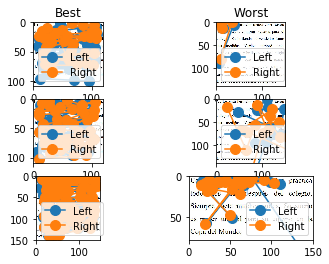

In [56]:
mask = (data.readingLesson != 73) & (data.questions > 3)
temp = data.loc[mask, :]

plot_extremes(temp, 3, with_data = True)

Look at some more eggregious contrasts in larger size.

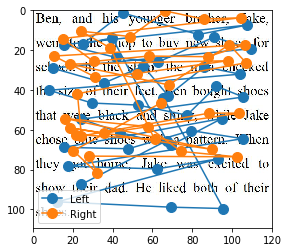

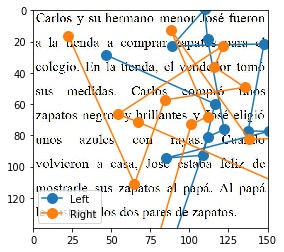

In [34]:
plot_fixation(temp.loc[66,:])
plot_fixation(temp.loc[269,:])

#### Consider a Single Text

Look at high and low ranked tests from within lesson 58.  


test  readingLesson  isOutloud  totalMicroseconds  questions  \
Best  66   1139             58          1            9764689        6.0   
      97   1235             58          1           15209515        6.0   
      157  1384             58          1           15899414        6.0   
Worst 121  1297             58          1           33238122        6.0   
      170  1421             58          1           49931274        6.0   
      124  1307             58          1           65859716        6.0   

           rightAnswers                                              gazes  \
Best  66            6.0  [{"L":{"X":17.171697807312011,"Y":83.435592341...   
      97            6.0  [{"L":{"X":29.747816276550296,"Y":-8.366009902...   
      157           6.0  [{"L":{"X":10.20084686279297,"Y":21.7488136768...   
Worst 121           2.0  [{"L":{"X":30.917988967895511,"Y":47.909605193...   
      170           2.0  [{"L":{"X":6.8152896881103517,"Y":32.515667366...   
      124           2.0  [{"L":{"X":1.9509298324584963,"Y":-21.47618622...   

                                                   fixations version  words  \
Best  66   {"L":[{"X":24.3,"Y":87.412500000000009,"T":197...      v1     60   
      97   {"L":[{"X":16.875,"Y":0.675,"T":3268782,"D":78...      v1     60   
      157  {"L":[{"X":12.825000000000001,"Y":13.162500000...      v1     60   
Worst 121  {"L":[{"X":37.800000000000004,"Y":10.4625,"T":...      v1     60   
      170  {"L":[{"X":5.0625,"Y":26.6625,"T":8504415,"D":...      v1     60   
      124  {"L":[{"X":-6.75,"Y":-44.8875,"T":5278889,"D":...      v1     60   

           ...  ageMax  patient    birthday  gender  country      age  \
Best  66   ...       5      783  1951-07-31       m       GB  66.7515   
      97   ...       5      829  1986-11-05       f       GB  31.6797   
      157  ...       5      881  1980-06-19       m       GB  38.4038   
Worst 121  ...       5      846  1969-08-03       m       GB  49.0103   
      170  ...       5      894  2011-02-12       f       GB   7.8357   
      124  ...       5      850  2011-02-25       m       GB   7.4689   

                     dateAdded comp_score    read_speed  reading_rank  
Best  66   2018-05-01 03:01:43   1.000000  1.627448e+05           3.0  
      97   2018-07-11 01:52:54   1.000000  2.534919e+05           5.0  
      157  2018-11-14 05:35:57   1.000000  2.649902e+05           8.0  
Worst 121  2018-08-07 03:33:25   0.333333  5.539687e+05         319.0  
      170  2018-12-14 03:49:54   0.333333  8.321879e+05         321.0  
      124  2018-08-15 04:01:53   0.333333  1.097662e+06         322.0  

[6 rows x 24 columns]

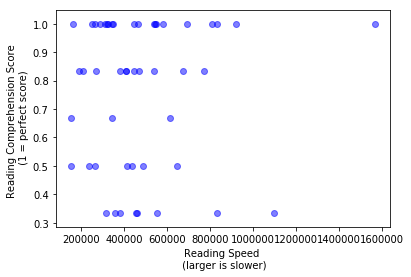

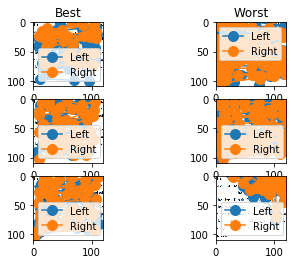

In [59]:
mask = (data.readingLesson == 58) & (data.questions > 3)
temp = data.loc[mask, :]
plot_speed_comp(temp)
plot_extremes(temp, 3, with_data = True)


Some of the high rankers in larger size.

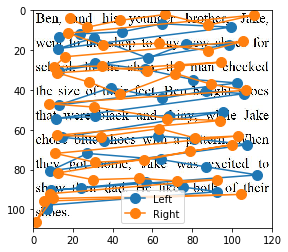

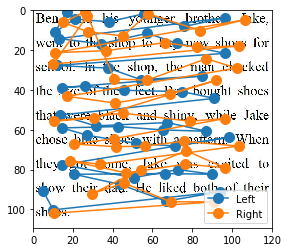

In [60]:
plot_fixation(temp.loc[157,:]) # best
plot_fixation(temp.loc[97,:]) # best

Some of the low rankers in larger size.

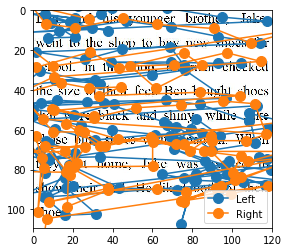

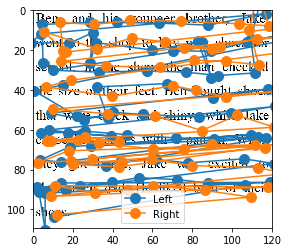

In [61]:
plot_fixation(temp.loc[121,:]) # worst
plot_fixation(temp.loc[170,:]) # worst

#### Consider Only Students Reading Age Appropriate Texts

Note, only 42 obsvs meet this requirement. Almost all in lesson 55 from Paraguay with age range between 8 and 11 all read aloud.  
Also note, text 70 has agemax = 100.  

In [64]:
data.loc[46,['ageMin', 'ageMax']]

ageMin     8
ageMax    11
Name: 46, dtype: object

In [65]:
mask = ((data.age > data.ageMin) & (data.age < data.ageMax)) & (data.questions > 3)
temp = data.loc[mask, :]

test  readingLesson  isOutloud  totalMicroseconds  questions  \
Best  51   1108             55          1           37587575        6.0   
      46   1094             55          1           40963846        6.0   
      48   1100             55          1           41458877        6.0   
      47   1096             55          1           53653027        6.0   
Worst 41   1077             55          1           46588891        6.0   
      367  2327             70          1           61033590        4.0   
      32   1049             55          1            2339974        6.0   
      54   1114             55          1            3765600        6.0   

           rightAnswers                                              gazes  \
Best  51            6.0  [{"L":{"X":64.418393982781311,"Y":44.264756052...   
      46            6.0  [{"L":{"X":-38.368055555555557,"Y":-23.6111111...   
      48            6.0  [{"L":{"X":37.134176757600571,"Y":65.699519448...   
      47            6.0  [{"L":{"X":52.671803050571022,"Y":74.112457840...   
Worst 41            3.0  [{"L":{"X":53.958511034647621,"Y":69.424092381...   
      367           2.0                                                NaN   
      32            2.0  [{"L":{"X":24.945329772101509,"Y":7.0567866254...   
      54            2.0  [{"L":{"X":67.305977291531036,"Y":1.9524044383...   

                                                   fixations version  words  \
Best  51   {"L":[{"X":73.361111111111114,"Y":-20.40740740...      v1     85   
      46   {"L":[{"X":2.9513888888888888,"Y":-5.902777777...      v1     85   
      48   {"L":[{"X":32.465277777777779,"Y":58.732638888...      v1     85   
      47   {"L":[{"X":73.361111111111114,"Y":-12.31481481...      v1     85   
Worst 41   {"L":[{"X":50.49074074074074,"Y":65.6203703703...      v1     85   
      367  {"L":[{"X":62.4537037037037,"Y":86.73148148148...      v3     60   
      32   {"L":[{"X":24.62962962962963,"Y":4.04629629629...      v1     85   
      54   {"L":[{"X":64.56481481481481,"Y":1.23148148148...      v1     85   

           ...  ageMax  patient    birthday  gender  country      age  \
Best  51   ...      11      747  2008-05-03       f       PY   9.5606   
      46   ...      11      745  2007-11-26       m       PY   9.9959   
      48   ...      11      753  2007-09-08       m       PY  10.2122   
      47   ...      11      746  2008-05-29       f       PY   9.4894   
Worst 41   ...      11      730  2008-10-04       m       PY   9.1389   
      367  ...     100      214  2010-01-01     NaN       PY   8.5777   
      32   ...      11      766  2008-01-01       m       PY   9.8973   
      54   ...      11      766  2008-01-01       m       PY   9.9521   

                     dateAdded comp_score    read_speed  reading_rank  
Best  51   2017-11-24 05:53:44   1.000000  4.422068e+05          24.0  
      46   2017-11-24 05:37:48   1.000000  4.819276e+05          27.0  
      48   2017-11-24 05:43:37   1.000000  4.877515e+05          28.0  
      47   2017-11-24 05:39:48   1.000000  6.312121e+05          39.0  
Worst 41   2017-11-24 05:09:06   0.500000  5.481046e+05         281.0  
      367  2018-07-31 06:47:57   0.500000  1.017226e+06         291.0  
      32   2017-11-24 04:07:40   0.333333  2.752911e+04         310.0  
      54   2017-12-14 06:08:57   0.333333  4.430118e+04         311.0  

[8 rows x 24 columns]

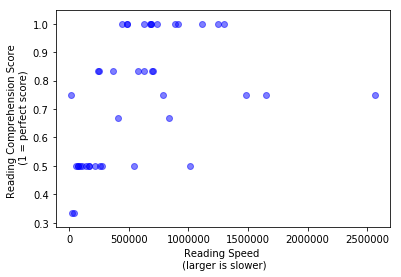

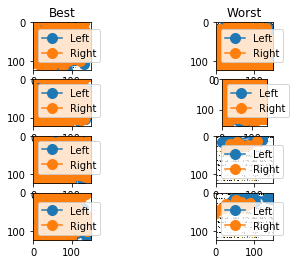

In [66]:
plot_speed_comp(temp)
plot_extremes(temp, 4, with_data = True)

Excepting the outliers in slow reading, the differences in fixations
appear subtle...

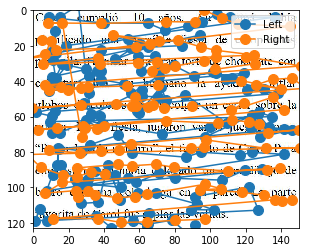

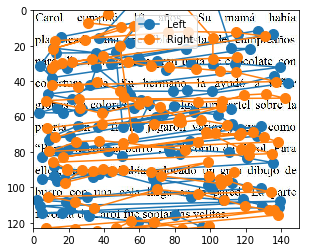

In [71]:
plot_fixation(temp.loc[48,:]) # best
#plot_fixation(temp.loc[47,:]) # best
plot_fixation(temp.loc[41,:]) # worst
#plot_fixation(temp.loc[367,:]) # worst
#plot_fixation(temp.loc[54,:]) # worst

The test with the slowest 0.5 comprehension score looks much more disordered than than the fastest test with 0.333 comprehension score. This suggests that maybe speed is a more important predictor of disordered fixations than comprhension...

#### Consider Only Tests with 1.0 Comprehension

Consider only tests with reading comprehension score of 1 (on more than 3 
questions) to see if there  are obvious eye movement differences for slow 
yet compreending readers and fast yet comprehending readers.  

When differentiating only by time like this there appears to be significant differences in the state of the fixaitions.

test  readingLesson  isOutloud  totalMicroseconds  questions  \
Best  66   1139             58          1            9764689        6.0   
      97   1235             58          1           15209515        6.0   
      254  2037             46          1           18388397        5.0   
Worst 134  1327             67          0          288152717        6.0   
      138  1331             61          0          216845632        5.0   
      302  2160             72          1          311416669        4.0   

           rightAnswers                                              gazes  \
Best  66            6.0  [{"L":{"X":17.171697807312011,"Y":83.435592341...   
      97            6.0  [{"L":{"X":29.747816276550296,"Y":-8.366009902...   
      254           5.0  [{"L":{"X":9.0666163762410488,"Y":7.4804696694...   
Worst 134           6.0  [{"L":{"X":78.780562930636933,"Y":-15.07951189...   
      138           5.0  [{"L":{"X":9.3324224683973522,"Y":66.764079994...   
      302           4.0                                                NaN   

                                                   fixations version  words  \
Best  66   {"L":[{"X":24.3,"Y":87.412500000000009,"T":197...      v1     60   
      97   {"L":[{"X":16.875,"Y":0.675,"T":3268782,"D":78...      v1     60   
      254  {"L":[{"X":11.611111111111111,"Y":7.3888888888...      v3     70   
Worst 134  {"L":[{"X":78.75,"Y":-8.9444444444444446,"T":2...      v1    100   
      138  {"L":[{"X":22.555555555555554,"Y":77.583333333...      v1     60   
      302  {"L":[{"X":69.666666666666671,"Y":-31.31481481...      v3     60   

           ...  ageMax  patient    birthday  gender  country      age  \
Best  66   ...       5      783  1951-07-31       m       GB  66.7515   
      97   ...       5      829  1986-11-05       f       GB  31.6797   
      254  ...       8        9  2010-01-01       m       PY   8.5530   
Worst 134  ...      12      857  1985-04-29       f       GB  33.3361   
      138  ...       9      857  1985-04-29       f       GB  33.3361   
      302  ...       7      230  2008-01-01     NaN       PY  10.5763   

                     dateAdded comp_score    read_speed  reading_rank  
Best  66   2018-05-01 03:01:43        1.0  1.627448e+05           3.0  
      97   2018-07-11 01:52:54        1.0  2.534919e+05           5.0  
      254  2018-07-22 20:05:49        1.0  2.626914e+05           6.0  
Worst 134  2018-08-30 01:36:39        1.0  2.881527e+06         104.0  
      138  2018-08-30 01:52:37        1.0  3.614094e+06         111.0  
      302  2018-07-30 10:49:17        1.0  5.190278e+06         116.0  

[6 rows x 24 columns]

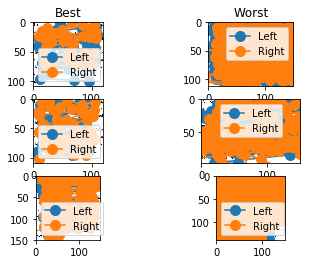

In [76]:
mask = (data.comp_score == 1)   & (data.questions > 3)
temp = data.loc[mask, :]

plot_extremes(temp, 3, with_data = True)

High Ranked fixation

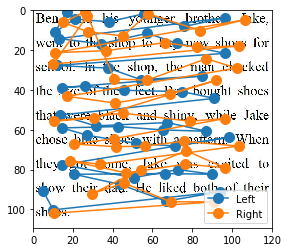

In [77]:
plot_fixation(temp.loc[97,:]) # best

Low Ranked fixation

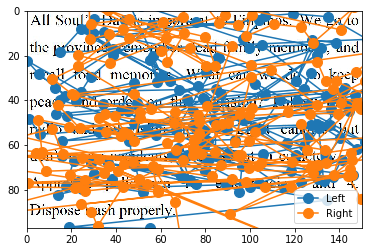

In [78]:
plot_fixation(temp.loc[138,:]) # worst